# Perturb-seq K562 co-expression

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import itertools
from pybedtools import BedTool
import pickle as pkl
import gseapy as gp
from gseapy.plot import gseaplot

%matplotlib inline

In [2]:
pd.set_option('max_columns', None)

In [3]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [4]:
data_path = '/data_volume/memento/k562/'

### Read the guide labled K562 data

From perturbseq paper

In [5]:
adata = sc.read(data_path + 'h5ad/filtered-tf-perturbseq.h5ad')

In [6]:
guides = adata.obs.guides.drop_duplicates().tolist()
guides = [g for g in guides if ('INTER' not in g and 'nan' not in g)]
ko_genes = adata.obs.query('KO == 1')['KO_GENE'].drop_duplicates().tolist()

### Setup memento

In [7]:
adata.obs['q'] = 0.07

In [15]:
memento.setup_memento(adata, q_column='q', filter_mean_thresh=0.15)

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:68: RankWarning: Polyfit may be poorly conditioned


### Do a 1D test to find highly variable genes

In [16]:
wt_subset = adata[adata.obs.WT].copy().copy()
wt_subset.obs['group'] = 1
memento.create_groups(wt_subset, label_columns=['group'])
memento.compute_1d_moments(wt_subset, min_perc_group=.9)
memento.ht_1d_moments(
    wt_subset, 
    formula_like='1',
    cov_column='Inter', 
    num_boot=10000, 
    verbose=1,
    num_cpus=70)

[Parallel(n_jobs=70)]: Using backend LokyBackend with 70 concurrent workers.
[Parallel(n_jobs=70)]: Done  60 tasks      | elapsed:    0.8s
[Parallel(n_jobs=70)]: Done 310 tasks      | elapsed:    2.8s
[Parallel(n_jobs=70)]: Done 660 tasks      | elapsed:    5.6s
[Parallel(n_jobs=70)]: Done 1110 tasks      | elapsed:    8.9s
[Parallel(n_jobs=70)]: Done 1660 tasks      | elapsed:   13.2s
[Parallel(n_jobs=70)]: Done 2310 tasks      | elapsed:   18.2s
[Parallel(n_jobs=70)]: Done 3060 tasks      | elapsed:   24.4s
[Parallel(n_jobs=70)]: Done 3910 tasks      | elapsed:   31.1s
[Parallel(n_jobs=70)]: Done 4860 tasks      | elapsed:   38.9s
[Parallel(n_jobs=70)]: Done 5910 tasks      | elapsed:   46.7s
[Parallel(n_jobs=70)]: Done 7060 tasks      | elapsed:   55.8s
[Parallel(n_jobs=70)]: Done 7526 out of 7526 | elapsed:  1.0min finished


In [17]:
# wt_subset = sc.read(data_path + 'wt_1d.h5ad')

In [18]:
df = memento.get_1d_ht_result(wt_subset).query('~gene.str.startswith("MT-")', engine='python')

In [19]:
df['dv_fdr'] = memento.util._fdrcorrect(df['dv_pval'])

In [20]:
hvg = df.query('dv_fdr < 0.1 & dv_coef > 0').gene.tolist()

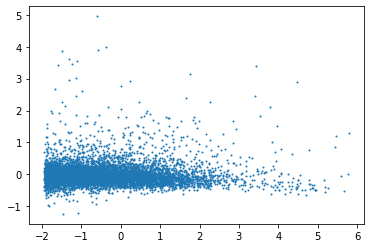

In [21]:
plt.scatter(df['de_coef'], df['dv_coef'], s=1)

### GSEA for WT

In [22]:
import gseapy as gp
from gseapy.plot import gseaplot


In [23]:
pre_res = gp.prerank(
    rnk=df[['gene','dv_coef']].sort_values('dv_coef'), 
    gene_sets='GO_Biological_Process_2018',
    processes=14,
    permutation_num=100, # reduce number to speed up testing
    outdir=None, seed=6)

In [24]:
terms = pre_res.res2d.index


In [25]:
gsea_table = pre_res.res2d.sort_index().sort_values('fdr')


In [26]:
gsea_table.query('es > 0').head(10)

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
regulation of immune response (GO:0050776),0.730837,2.088488,0.0,0.009694,252,28,TYROBP;IFITM1;CD3D;B2M;CD33;HLA-E;ICAM2;NCR3LG...,TYROBP;IFITM1;CD3D;B2M;CD33
cellular response to hormone stimulus (GO:0032870),0.770491,2.201558,0.0,0.009694,81,28,JUN;TFPI;SOCS2;AKR1C1;MEF2C;CTSL;ZFP36L1;LMO2;...,JUN;TFPI;SOCS2;AKR1C1;MEF2C;CTSL;ZFP36L1;LMO2;...
response to unfolded protein (GO:0006986),0.722181,2.096073,0.0,0.012926,44,29,HSPA1A;HSPA5;DNAJB4;HSPA8;DNAJB1;HERPUD1;HSP90...,HSPA1A;HSPA5;DNAJB4;HSPA8;DNAJB1;HERPUD1;HSP90...
defense response to bacterium (GO:0042742),0.764943,2.132035,0.0,0.014541,242,27,LYZ;PYCARD;RPL39;HIST1H2BJ;HIST1H2BK;HMGB2;HIS...,LYZ;PYCARD;RPL39;HIST1H2BJ;HIST1H2BK;HMGB2;HIS...
lymphocyte differentiation (GO:0030098),0.743540,1.997293,0.0,0.022158,74,18,CD3D;KLF6;PTPRC;DNAJB9;HHEX;RHOH;LYL1;CHD7;JAG...,CD3D;KLF6;PTPRC;DNAJB9;HHEX;RHOH
regulation of DNA binding (GO:0051101),0.725346,2.003885,0.0,0.024235,53,35,ID3;ID1;IGF1;JUN;HJURP;HMGB2;IFI16;HES1;PLAUR;...,ID3;ID1;IGF1;JUN;HJURP;HMGB2;IFI16;HES1;PLAUR
chaperone mediated protein folding requiring cofactor (GO:0051085),0.746605,2.008710,0.0,0.027144,25,18,HSPA1A;HSPA5;HSPA8;DNAJB1;HSPH1;HSPA4L;GAK;PTG...,HSPA1A;HSPA5;HSPA8;DNAJB1;HSPH1
negative regulation of apoptotic process (GO:0043066),0.528204,1.949702,0.0,0.056953,486,219,DHRS2;HSPA1A;APOE;HSPA5;IGF1;HSP90B1;SQSTM1;AR...,DHRS2;HSPA1A;APOE;HSPA5;IGF1;HSP90B1;SQSTM1;AR...
regulation of cell cycle (GO:0051726),0.552149,1.925963,0.0,0.058165,216,124,ID3;ID1;CCNB1;CDK1;JUN;CENPF;CKS2;PLK1;CCND1;C...,ID3;ID1;CCNB1;CDK1;JUN;CENPF;CKS2;PLK1;CCND1;C...


In [27]:
# # Define the gene sets

# stress_genes = list(set(gsea_table.query('es > 0').genes.iloc[2].split(';')) & set(hvg))
# bacteria_genes = list(set(gsea_table.query('es > 0').genes.iloc[3].split(';')) & set(hvg))
# immune_genes = list(set(gsea_table.query('es > 0').genes.iloc[0].split(';') +  gsea_table.query('es > 0').genes.iloc[4].split(';')) & set(hvg))

### Get HVG and LVG

In [28]:
hvg = df.query('dv_fdr < 0.05 & dv_coef > 1').gene.tolist()
lvg = df.query('dv_fdr < 0.05 & dv_coef < -0.5').gene.tolist()

Text(0, 0.5, 'Variability')

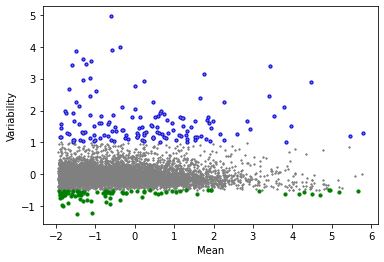

In [29]:
plt.scatter(df['de_coef'], df['dv_coef'], s=1, color='grey')
plt.scatter(df.query('gene in @hvg')['de_coef'], df.query('gene in @hvg')['dv_coef'], s=10, color='b')
plt.scatter(df['de_coef'], df['dv_coef'], s=1, color='grey')
plt.scatter(df.query('gene in @lvg')['de_coef'], df.query('gene in @lvg')['dv_coef'], s=10, color='g')
plt.xlabel('Mean'); plt.ylabel('Variability')

### Get cytokines

In [36]:
cytokines = pd.read_csv('mart_export.txt')['Gene name'].tolist()

In [37]:
df['cytokine'] = df['gene'].isin(cytokines)

In [38]:
df['cytokine'].sum()

29

In [39]:
cytokines = df.query('cytokine').gene.tolist()

(-1.0, 1.5)

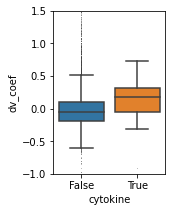

In [40]:
plt.figure(figsize=(2,3))
sns.boxplot(x='cytokine', y='dv_coef', data=df, fliersize=0.1)
plt.ylim(-1,1.5)

In [41]:
dv_cytokines = df.query('cytokine & dv_fdr < 0.1').gene.tolist()
df.query('cytokine & dv_fdr < 0.1')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,dv_fdr,cytokine
1627,IL20RB,-1.787209,0.037950,4.551063e-07,0.318886,0.143727,0.026397,0.091987,True
1849,CXCL3,-1.086986,0.028602,1.000829e-06,0.721656,0.124059,0.000076,0.001146,True
2133,TSLP,-1.427353,0.032918,1.264946e-05,0.546550,0.100861,0.000048,0.000884,True
2190,CXCL14,-1.703472,0.032712,9.272963e-06,-0.911718,0.229584,0.002300,0.013020,True
2549,VEGFA,-0.085674,0.016995,1.101198e-04,0.290479,0.082060,0.001430,0.009035,True
3184,TIMP1,1.759360,0.025643,5.756289e-08,3.132865,1.045900,0.000100,0.001363,True
3287,IL13RA1,-1.868375,0.041732,2.263586e-08,0.704446,0.201012,0.001355,0.008686,True
4810,IL23A,-1.112587,0.028470,3.981398e-07,0.519569,0.089809,0.000565,0.004605,True
6962,GDF15,1.142136,0.016518,2.538263e-09,1.807208,0.138331,0.000001,0.000123,True
7018,GPI,0.209889,0.013654,1.388347e-04,-0.310132,0.096488,0.001800,0.010703,True


### Memento

In [42]:
results = {}
moments = {}

In [43]:
for g in ko_genes:
    
    print(g)
    
    subset = adata[adata.obs.WT | (adata.obs.KO_GENE == g)].copy().copy()
    
    memento.create_groups(subset, label_columns=['KO'])
    memento.compute_1d_moments(subset, min_perc_group=.9)
    
    memento.ht_1d_moments(
        subset, 
        formula_like='1 + KO',
        cov_column='KO', 
        num_boot=20000, 
        verbose=1,
        num_cpus=70)
    guide_df = memento.get_1d_ht_result(subset)
    
    results[g] = memento.get_1d_ht_result(subset)
    moments[g] = memento.get_1d_moments(subset, groupby='KO')
    
#     results[g]['de_fdr'] = memento.util._fdrcorrect(results[g]['de_pval'])
#     results[g]['dv_fdr'] = memento.util._fdrcorrect(results[g]['dv_pval'])
    
    results[g]['class'] = results[g].gene.apply(lambda x: 'hvg' if x in hvg else 'lvg')

ELK1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=70)]: Using backend LokyBackend with 70 concurrent workers.
[Parallel(n_jobs=70)]: Done  60 tasks      | elapsed:    4.5s
[Parallel(n_jobs=70)]: Done 310 tasks      | elapsed:    8.5s
[Parallel(n_jobs=70)]: Done 660 tasks      | elapsed:   13.5s
[Parallel(n_jobs=70)]: Done 1110 tasks      | elapsed:   19.6s
[Parallel(n_jobs=70)]: Done 1660 tasks      | elapsed:   27.2s
[Parallel(n_jobs=70)]: Done 2310 tasks      | elapsed:   36.2s
[Parallel(n_jobs=70)]: Done 3060 tasks      | elapsed:   47.6s
[Parallel(n_jobs=70)]: Done 3910 tasks      | elapsed:   59.3s
[Parallel(n_jobs=70)]: Done 4860 tasks      | elapsed:  1.2min
[Parallel(n_jobs=70)]: Done 5910 tasks      | elapsed:  1.5min
[Parallel(n_j

ELF1


[Parallel(n_jobs=70)]: Using backend LokyBackend with 70 concurrent workers.
[Parallel(n_jobs=70)]: Done  60 tasks      | elapsed:    1.2s
[Parallel(n_jobs=70)]: Done 310 tasks      | elapsed:    5.0s
[Parallel(n_jobs=70)]: Done 660 tasks      | elapsed:   10.2s
[Parallel(n_jobs=70)]: Done 1110 tasks      | elapsed:   16.6s
[Parallel(n_jobs=70)]: Done 1660 tasks      | elapsed:   24.3s
[Parallel(n_jobs=70)]: Done 2310 tasks      | elapsed:   33.5s
[Parallel(n_jobs=70)]: Done 3060 tasks      | elapsed:   45.4s
[Parallel(n_jobs=70)]: Done 3910 tasks      | elapsed:   57.5s
[Parallel(n_jobs=70)]: Done 4860 tasks      | elapsed:  1.2min
[Parallel(n_jobs=70)]: Done 5910 tasks      | elapsed:  1.4min
[Parallel(n_jobs=70)]: Done 7060 tasks      | elapsed:  1.7min
[Parallel(n_jobs=70)]: Done 7443 out of 7443 | elapsed:  2.0min finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.C

IRF1


[Parallel(n_jobs=70)]: Using backend LokyBackend with 70 concurrent workers.
[Parallel(n_jobs=70)]: Done  60 tasks      | elapsed:    1.0s
[Parallel(n_jobs=70)]: Done 310 tasks      | elapsed:    4.1s
[Parallel(n_jobs=70)]: Done 660 tasks      | elapsed:    8.1s
[Parallel(n_jobs=70)]: Done 1110 tasks      | elapsed:   13.1s
[Parallel(n_jobs=70)]: Done 1660 tasks      | elapsed:   19.3s
[Parallel(n_jobs=70)]: Done 2310 tasks      | elapsed:   26.6s
[Parallel(n_jobs=70)]: Done 3060 tasks      | elapsed:   35.9s
[Parallel(n_jobs=70)]: Done 3910 tasks      | elapsed:   45.5s
[Parallel(n_jobs=70)]: Done 4860 tasks      | elapsed:   57.1s
[Parallel(n_jobs=70)]: Done 5910 tasks      | elapsed:  1.1min
[Parallel(n_jobs=70)]: Done 7060 tasks      | elapsed:  1.4min
[Parallel(n_jobs=70)]: Done 7422 out of 7422 | elapsed:  1.5min finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.C

ETS1


[Parallel(n_jobs=70)]: Using backend LokyBackend with 70 concurrent workers.
[Parallel(n_jobs=70)]: Done  60 tasks      | elapsed:    1.1s
[Parallel(n_jobs=70)]: Done 310 tasks      | elapsed:    4.7s
[Parallel(n_jobs=70)]: Done 660 tasks      | elapsed:    9.4s
[Parallel(n_jobs=70)]: Done 1110 tasks      | elapsed:   15.2s
[Parallel(n_jobs=70)]: Done 1660 tasks      | elapsed:   22.4s
[Parallel(n_jobs=70)]: Done 2310 tasks      | elapsed:   31.0s
[Parallel(n_jobs=70)]: Done 3060 tasks      | elapsed:   41.9s
[Parallel(n_jobs=70)]: Done 3910 tasks      | elapsed:   53.1s
[Parallel(n_jobs=70)]: Done 4860 tasks      | elapsed:  1.1min
[Parallel(n_jobs=70)]: Done 5910 tasks      | elapsed:  1.3min
[Parallel(n_jobs=70)]: Done 7060 tasks      | elapsed:  1.6min
[Parallel(n_jobs=70)]: Done 7478 out of 7478 | elapsed:  1.8min finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.C

EGR1


[Parallel(n_jobs=70)]: Using backend LokyBackend with 70 concurrent workers.
[Parallel(n_jobs=70)]: Done  60 tasks      | elapsed:    1.1s
[Parallel(n_jobs=70)]: Done 310 tasks      | elapsed:    4.4s
[Parallel(n_jobs=70)]: Done 660 tasks      | elapsed:    8.8s
[Parallel(n_jobs=70)]: Done 1110 tasks      | elapsed:   14.2s
[Parallel(n_jobs=70)]: Done 1660 tasks      | elapsed:   21.0s
[Parallel(n_jobs=70)]: Done 2310 tasks      | elapsed:   29.0s
[Parallel(n_jobs=70)]: Done 3060 tasks      | elapsed:   39.3s
[Parallel(n_jobs=70)]: Done 3910 tasks      | elapsed:   49.7s
[Parallel(n_jobs=70)]: Done 4860 tasks      | elapsed:  1.0min
[Parallel(n_jobs=70)]: Done 5910 tasks      | elapsed:  1.2min
[Parallel(n_jobs=70)]: Done 7060 tasks      | elapsed:  1.5min
[Parallel(n_jobs=70)]: Done 7469 out of 7469 | elapsed:  1.7min finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.C

YY1


[Parallel(n_jobs=70)]: Using backend LokyBackend with 70 concurrent workers.
[Parallel(n_jobs=70)]: Done  60 tasks      | elapsed:    1.1s
[Parallel(n_jobs=70)]: Done 310 tasks      | elapsed:    4.9s
[Parallel(n_jobs=70)]: Done 660 tasks      | elapsed:    9.9s
[Parallel(n_jobs=70)]: Done 1110 tasks      | elapsed:   15.9s
[Parallel(n_jobs=70)]: Done 1660 tasks      | elapsed:   23.4s
[Parallel(n_jobs=70)]: Done 2310 tasks      | elapsed:   32.2s
[Parallel(n_jobs=70)]: Done 3060 tasks      | elapsed:   43.4s
[Parallel(n_jobs=70)]: Done 3910 tasks      | elapsed:   55.0s
[Parallel(n_jobs=70)]: Done 4860 tasks      | elapsed:  1.2min
[Parallel(n_jobs=70)]: Done 5910 tasks      | elapsed:  1.4min
[Parallel(n_jobs=70)]: Done 7060 tasks      | elapsed:  1.7min
[Parallel(n_jobs=70)]: Done 7329 out of 7329 | elapsed:  1.8min finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.C

GABPA


[Parallel(n_jobs=70)]: Using backend LokyBackend with 70 concurrent workers.
[Parallel(n_jobs=70)]: Done  60 tasks      | elapsed:    1.2s
[Parallel(n_jobs=70)]: Done 310 tasks      | elapsed:    4.8s
[Parallel(n_jobs=70)]: Done 660 tasks      | elapsed:    9.5s
[Parallel(n_jobs=70)]: Done 1110 tasks      | elapsed:   15.3s
[Parallel(n_jobs=70)]: Done 1660 tasks      | elapsed:   22.4s
[Parallel(n_jobs=70)]: Done 2310 tasks      | elapsed:   30.9s
[Parallel(n_jobs=70)]: Done 3060 tasks      | elapsed:   41.7s
[Parallel(n_jobs=70)]: Done 3910 tasks      | elapsed:   52.8s
[Parallel(n_jobs=70)]: Done 4860 tasks      | elapsed:  1.1min
[Parallel(n_jobs=70)]: Done 5910 tasks      | elapsed:  1.3min
[Parallel(n_jobs=70)]: Done 7060 tasks      | elapsed:  1.6min
[Parallel(n_jobs=70)]: Done 7405 out of 7405 | elapsed:  1.8min finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.C

E2F4


[Parallel(n_jobs=70)]: Using backend LokyBackend with 70 concurrent workers.
[Parallel(n_jobs=70)]: Done  60 tasks      | elapsed:    1.2s
[Parallel(n_jobs=70)]: Done 310 tasks      | elapsed:    4.6s
[Parallel(n_jobs=70)]: Done 660 tasks      | elapsed:    9.3s
[Parallel(n_jobs=70)]: Done 1110 tasks      | elapsed:   15.0s
[Parallel(n_jobs=70)]: Done 1660 tasks      | elapsed:   22.1s
[Parallel(n_jobs=70)]: Done 2310 tasks      | elapsed:   30.5s
[Parallel(n_jobs=70)]: Done 3060 tasks      | elapsed:   41.3s
[Parallel(n_jobs=70)]: Done 3910 tasks      | elapsed:   52.2s
[Parallel(n_jobs=70)]: Done 4860 tasks      | elapsed:  1.1min
[Parallel(n_jobs=70)]: Done 5910 tasks      | elapsed:  1.3min
[Parallel(n_jobs=70)]: Done 7060 tasks      | elapsed:  1.6min
[Parallel(n_jobs=70)]: Done 7438 out of 7438 | elapsed:  1.8min finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.C

NR2C2


[Parallel(n_jobs=70)]: Using backend LokyBackend with 70 concurrent workers.
[Parallel(n_jobs=70)]: Done  60 tasks      | elapsed:    1.1s
[Parallel(n_jobs=70)]: Done 310 tasks      | elapsed:    4.6s
[Parallel(n_jobs=70)]: Done 660 tasks      | elapsed:    9.2s
[Parallel(n_jobs=70)]: Done 1110 tasks      | elapsed:   14.9s
[Parallel(n_jobs=70)]: Done 1660 tasks      | elapsed:   21.9s
[Parallel(n_jobs=70)]: Done 2310 tasks      | elapsed:   30.3s
[Parallel(n_jobs=70)]: Done 3060 tasks      | elapsed:   40.9s
[Parallel(n_jobs=70)]: Done 3910 tasks      | elapsed:   51.7s
[Parallel(n_jobs=70)]: Done 4860 tasks      | elapsed:  1.1min
[Parallel(n_jobs=70)]: Done 5910 tasks      | elapsed:  1.3min
[Parallel(n_jobs=70)]: Done 7060 tasks      | elapsed:  1.6min
[Parallel(n_jobs=70)]: Done 7400 out of 7400 | elapsed:  1.7min finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.C

CREB1


[Parallel(n_jobs=70)]: Using backend LokyBackend with 70 concurrent workers.
[Parallel(n_jobs=70)]: Done  60 tasks      | elapsed:    1.0s
[Parallel(n_jobs=70)]: Done 310 tasks      | elapsed:    3.9s
[Parallel(n_jobs=70)]: Done 660 tasks      | elapsed:    7.9s
[Parallel(n_jobs=70)]: Done 1110 tasks      | elapsed:   12.9s
[Parallel(n_jobs=70)]: Done 1660 tasks      | elapsed:   18.9s
[Parallel(n_jobs=70)]: Done 2310 tasks      | elapsed:   26.0s
[Parallel(n_jobs=70)]: Done 3060 tasks      | elapsed:   35.2s
[Parallel(n_jobs=70)]: Done 3910 tasks      | elapsed:   44.6s
[Parallel(n_jobs=70)]: Done 4860 tasks      | elapsed:   56.2s
[Parallel(n_jobs=70)]: Done 5910 tasks      | elapsed:  1.1min
[Parallel(n_jobs=70)]: Done 7060 tasks      | elapsed:  1.3min
[Parallel(n_jobs=70)]: Done 7424 out of 7424 | elapsed:  1.5min finished


In [51]:
filtered_results = {}
for g in ko_genes:
    
    filtered_results[g] = results[g].copy()
    filtered_results[g]['class'] = filtered_results[g].gene.apply(lambda x: 'hvg' if x in hvg else ('lvg' if x in lvg else 'else'))
    filtered_results[g] = filtered_results[g][filtered_results[g]['class'] != 'else']
    filtered_results[g]['de_fdr'] = memento.util._fdrcorrect(filtered_results[g]['de_pval'])
    filtered_results[g]['dv_fdr'] = memento.util._fdrcorrect(filtered_results[g]['dv_pval'])
    
    print(g)
    print(filtered_results[g].query('dv_fdr < 0.1')[['gene', 'de_coef','dv_coef', 'class', 'dv_pval','dv_fdr']])

ELK1
        gene   de_coef   dv_coef class   dv_pval    dv_fdr
668      CFH -0.110796 -1.118351   hvg  0.001000  0.073996
4814     LYZ -0.419173 -1.994510   hvg  0.000175  0.038870
5130  RNASE1 -0.153838 -1.140506   hvg  0.000650  0.072146
ELF1
Empty DataFrame
Columns: [gene, de_coef, dv_coef, class, dv_pval, dv_fdr]
Index: []
IRF1
       gene   de_coef   dv_coef class   dv_pval    dv_fdr
3140  TIMP1 -0.039347 -2.620467   hvg  0.000039  0.008677
ETS1
           gene   de_coef   dv_coef class   dv_pval    dv_fdr
2951        VGF -0.068067 -2.364705   hvg  0.002550  0.093070
3142       SAT1 -0.096577 -1.992446   hvg  0.000379  0.041483
3166      TIMP1 -0.024537 -2.207701   hvg  0.001350  0.059127
4407      NEAT1 -0.050916 -0.673815   hvg  0.000227  0.041483
5631  TNFRSF12A  0.055658 -0.650739   hvg  0.000850  0.059127
6639      AURKA -0.002081 -0.360447   hvg  0.001300  0.059127
EGR1
Empty DataFrame
Columns: [gene, de_coef, dv_coef, class, dv_pval, dv_fdr]
Index: []
YY1
           gene  

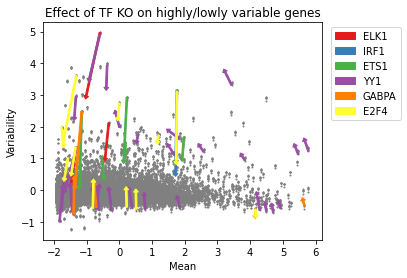

In [66]:
plt.figure(figsize=(5, 4))
color_idx = 0
for g in ko_genes:
    dv_genes = filtered_results[g].query('dv_fdr < 0.1').gene.tolist()
    if len(dv_genes) == 0:
        continue
    moment_df = moments[g]
    
    color = sns.color_palette('Set1')[color_idx]
    color_idx += 1
    
    plt.scatter(moment_df[0]['KO_0'], moment_df[1]['KO_0'], s=1, color='grey')
#     plt.scatter(moment_df[0].query('gene in @dv_genes')['KO_0'], moment_df[1].query('gene in @dv_genes')['KO_0'], s=10)
#     plt.scatter(moment_df[0].query('gene in @dv_genes')['KO_1'], moment_df[1].query('gene in @dv_genes')['KO_1'], s=10)

    for idx, dv_g in enumerate(dv_genes):

        x,y = moment_df[0].query('gene =="{}"'.format(dv_g))['KO_0'].iloc[0], moment_df[1].query('gene =="{}"'.format(dv_g))['KO_0'].iloc[0]
        dx = moment_df[0].query('gene =="{}"'.format(dv_g))['KO_1'].iloc[0] - x
        dy = moment_df[1].query('gene =="{}"'.format(dv_g))['KO_1'].iloc[0] - y
        if idx == 0:
            plt.arrow(x,y, dx, dy, width=0.05, head_length=0.1, color=color, label=g)
        else:
            plt.arrow(x,y, dx, dy, width=0.05, head_length=0.1, color=color)
    plt.xlabel('Mean'); plt.ylabel('Variability'); plt.title('Effect of TF KO on highly/lowly variable genes')
plt.legend( bbox_to_anchor=(1.3, 1))

In [ ]:

for g in ko_genes:
    
    print(g)
    
    subset = adata[adata.obs.WT | (adata.obs.KO_GENE == g)].copy().copy()
    
    subset.obs['group'] = 1
    
    memento.create_groups(subset, label_columns=['KO'])
    memento.compute_1d_moments(subset, min_perc_group=.9)
    
    m_df, var_df = memento.get_1d_moments(subset, groupby='KO')
    
    var_df0 = var_df[['gene', 'KO_0']].rename(columns={'KO_0':'var'})
    var_df0['group'] = 'WT'
    var_df1 = var_df[['gene', 'KO_1']].rename(columns={'KO_1':'var'})
    var_df1['group'] = 'KO'
    
    var_df = pd.concat([var_df0, var_df1])
    var_df['cytokine'] = var_df['gene'].isin(cytokines)
    
    plt.figure(figsize=(2,2))
    sns.boxplot(x='cytokine', y='var', hue='group', data=var_df, fliersize=0.1)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.title(g)
    plt.ylim(-0.5, 1.2)
    
#     plt.figure(figsize=(2,3))
#     sns.boxplot(x='cytokine', y='group_1', data=var_df)

In [ ]:
for g in ko_genes:
    
    print(g)
    
    subset = adata[adata.obs.WT | (adata.obs.KO_GENE == g), cytokines].copy().copy()
    
    memento.create_groups(subset, label_columns=['KO', 'guides'])
    memento.compute_1d_moments(subset, min_perc_group=.9)
    
    memento.ht_1d_moments(
        subset, 
        formula_like='1 + KO',
        cov_column='KO', 
        num_boot=20000, 
        verbose=1,
        num_cpus=14)
    guide_df = memento.get_1d_ht_result(subset)
    
    results[g] = memento.get_1d_ht_result(subset)
    moments[g] = memento.get_1d_moments(subset, groupby='KO')

In [123]:
dv_genes = results['YY1'].query('dv_fdr < 0.1').gene.tolist()
moment_df = moments['YY1']

In [136]:
g

'ID3'

In [140]:
moment_df[0].query('gene =="{}"'.format(g))['KO_0'].iloc[0]

-0.39352927

### YY1 - Individual example

Text(0.5, 1.0, 'Effect of YY1 KO on highly/lowly variable genes')

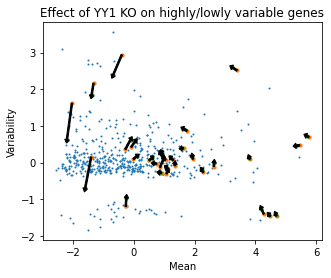

In [144]:
plt.figure(figsize=(5, 4))
plt.scatter(moment_df[0]['KO_0'], moment_df[1]['KO_0'], s=1)
plt.scatter(moment_df[0].query('gene in @dv_genes')['KO_0'], moment_df[1].query('gene in @dv_genes')['KO_0'], s=10)
plt.scatter(moment_df[0].query('gene in @dv_genes')['KO_1'], moment_df[1].query('gene in @dv_genes')['KO_1'], s=10)

for g in dv_genes:
    
    x,y = moment_df[0].query('gene =="{}"'.format(g))['KO_0'].iloc[0], moment_df[1].query('gene =="{}"'.format(g))['KO_0'].iloc[0]
    dx = moment_df[0].query('gene =="{}"'.format(g))['KO_1'].iloc[0] - x
    dy = moment_df[1].query('gene =="{}"'.format(g))['KO_1'].iloc[0] - y
    plt.arrow(x,y, dx, dy, width=0.05, head_length=0.1, color='black')
plt.xlabel('Mean'); plt.ylabel('Variability'); plt.title('Effect of YY1 KO on highly/lowly variable genes')

In [45]:
guide_df = memento.get_1d_ht_result(subset)

In [49]:
guide_df['de_fdr'] = memento.util._fdrcorrect(guide_df['de_pval'])
guide_df['dv_fdr'] = memento.util._fdrcorrect(guide_df['dv_pval'])

In [50]:
guide_df.query('dv_fdr < 0.1')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr,dv_fdr
74,FN1,-0.462806,0.107527,0.000226,-1.839776,0.289305,0.000088,0.068673,0.037803
353,LYZ,-0.390178,0.130690,0.002700,-1.559115,0.330854,0.000145,0.235326,0.037803


In [ ]:
for g, result in result_1d_dict.items():
    
    result.to_csv(data_path + '/result_1d/{}.csv'.format(g), index=False)